In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Group Project/Intra.zip' -d '/content/drive/My Drive/Group Project/Intra'

## Functions

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import json
import os
import h5py
import numpy as np
import re
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, ReLU, BatchNormalization, Reshape, Softmax, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import gc
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sys

In [ ]:
TRAIN_DATA_PATH = '/content/drive/My Drive/Group Project/Intra/train'
TEST_DATA_PATH = '/content/drive/My Drive/Group Project/Intra/test'

In [ ]:
# Function to read MEG data from h5 files
def read_meg_data(file_path, filename):
    with h5py.File(file_path, 'r') as file:
        temp = filename.split('_')[:-1]
        dataset_name = "_".join(temp)
        meg_data = file.get(dataset_name)[()]
        return meg_data


# Function to preprocess data
def preprocess_data(data):
    # Randomly select 248*3 columns from the 35624 columns
    selected_columns = np.random.choice(data.shape[1], size=data.shape[0]*3, replace=False)
    processed_data = data[:, selected_columns]
    return processed_data

# Function to load data and labels from a directory
def load_data_from_directory(directory):
    data = []
    labels = []

    for file_name in os.listdir(directory):
        if file_name.endswith('.h5'):
            file_path = os.path.join(directory, file_name)
            meg_data = read_meg_data(file_path, file_name)
            processed_data = preprocess_data(meg_data)
            data.append(processed_data)

            # Assuming your file names are like "class1_capture1.h5", extract class label
            label = file_name.split('_')[1]
            labels.append(label)

    return np.array(data), np.array(labels)

In [ ]:
## This function takes a dictionary of parameters as input and create and compile the model with that param
# This to make more readable the loop
def create_model(params):
    model = models.Sequential([
    layers.Conv2D(128, kernel_size=params['kernel_size1'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(params['dropout_rate1']),
    layers.BatchNormalization(),
    layers.Conv2D(512, kernel_size=params['kernel_size1'], activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(params['dropout_rate1']),
    layers.Conv2D(256, kernel_size=params['kernel_size2'], activation='relu'),
    layers.MaxPooling2D(2, 3),
    layers.Conv2D(128, kernel_size=params['kernel_size2'], activation='relu'),
    layers.MaxPooling2D(2, 3),
    layers.Dropout(params['dropout_rate1']),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learn_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def create_model_simple(params):
    model = models.Sequential([
        layers.Conv2D(4, kernel_size=params['kernel_size1'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        layers.MaxPooling2D(5, 5),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=params['kernel_size2'], activation='relu'),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(params['l2_lambda'])),
        layers.Dropout(params['dropout_rate1']),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(params['l2_lambda'])),
        layers.Dropout(params['dropout_rate1']),
        layers.Dense((4), activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learn_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)

## Data load and processing


In [ ]:
X_train, y_train = load_data_from_directory(TRAIN_DATA_PATH)

In [ ]:
y_train.shape

(32,)

In [ ]:
X_test, y_test = load_data_from_directory(TEST_DATA_PATH)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32, 248, 744), (32,), (8, 248, 744), (8,))

In [ ]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=32)

In [ ]:
for i in y_train:
  print(i)

working
story
story
105923
motor
motor
motor
story
working
105923
105923
story
motor
working
working
working
105923
story
working
motor
story
motor
105923
105923


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_val = label_encoder.fit_transform(y_val)

story = 2 motor = 1 rest = 0 working = 3


In [ ]:
y_train.shape

(24,)

In [ ]:
for i in y_train:
  print(i)

3
2
2
0
1
1
1
2
3
0
0
2
1
3
3
3
0
2
3
1
2
1
0
0


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val = scaler.fit_transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [ ]:
# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
K.clear_session()
gc.collect()

0

## Export Objects


In [ ]:
import pickle

In [ ]:
objects_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

In [ ]:
with open('/content/drive/My Drive/Group Project/saved_objects_intra.pkl', 'wb') as f:
    pickle.dump(objects_to_save, f)

## Import Objects

In [ ]:
import pickle
with open('/content/drive/My Drive/Group Project/saved_objects_intra.pkl', 'rb') as f:
    globals().update(pickle.load(f))

## Grid Search

In [ ]:
# Define the range of values for each hyperparameter -----
param_grid = {
    'kernel_size1': [(31, 93), (15, 63)],
    'kernel_size2': [(31, 93),(15, 63)],
    'dropout_rate1': [0.35, 0.5],
    'learn_rate': [0.0001],
    'l2_lambda': [0.01]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

results = []
best_accuracy = 0.0
best_params = None
size_best_model = 0
best_history = None

for params in tqdm(grid):
    print("Parameters of the iteration: ", params)

    # Build and compile the model with the current set of hyperparameters
    model = create_model(params)

    checkpoint_path = checkpoint_path = '/content/drive/My Drive/Group Project/Models_Simple_Intra/best_model_grid.h5'
    model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=100)

    # Train the model
    history = model.fit(X_train, y_train, batch_size=12, epochs=150, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

    # Evaluate the model on the validation set
    val_accuracy = max(history.history['val_accuracy'])  # Get the best validation accuracy

    # Update the best model if the current model is better
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        size_best_model = model.count_params()  # Get the number of parameters in the model
        best_history = history
        # Optionally, save the model
        model.save('/content/drive/My Drive/Group Project/Models_Simple_Intra/best_model_grid_overall.h5')


    # Update the results dictionary
    results.append({
        'kernel_size1': params['kernel_size1'],
        'kernel_size2': params['kernel_size2'],
        'dropout_rate1': params['dropout_rate1'],
        'learn_rate': params['learn_rate'],
        'val_accuracy': val_accuracy
    })


    # Clear session, delete model, and collect garbage
    K.clear_session()
    del model
    del history
    del val_accuracy
    gc.collect()


# Print the best model's information
print("Best model's accuracy:", best_accuracy)
print("Best model's parameters:", best_params)
print("Size of the best model (number of parameters):", size_best_model)

# At the end you shoul end up with the model that has acheived the best accuracy on the test set (formed by the 3 test set in cross folder merged)
# and also the best scaling for the model -- the model is saved in best_model_path-

In [ ]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Optionally, save the DataFrame to a CSV file
results_df.to_csv('/content/drive/My Drive/Group Project/Models_Simple_Intra/grid_search_results.csv', index=False)

In [ ]:
results_df

,kernel_size1,kernel_size2,dropout_rate1,learn_rate,l2_lambda,val_accuracy
0,"(31, 93)","(31, 93)",0.35,0.0001,0.001,0.375
1,"(31, 93)","(31, 93)",0.35,0.0010,0.001,0.625
2,"(31, 93)","(31, 93)",0.35,0.0001,0.010,0.750
3,"(31, 93)","(31, 93)",0.35,0.0010,0.010,0.500
4,"(31, 93)","(15, 63)",0.35,0.0001,0.001,0.750
5,"(31, 93)","(15, 63)",0.35,0.0010,0.001,0.500
6,"(31, 93)","(15, 63)",0.35,0.0001,0.010,1.000
7,"(31, 93)","(15, 63)",0.35,0.0010,0.010,0.875
8,"(15, 63)","(31, 93)",0.35,0.0001,0.001,1.000
9,"(15, 63)","(31, 93)",0.35,0.0010,0.001,0.750


In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

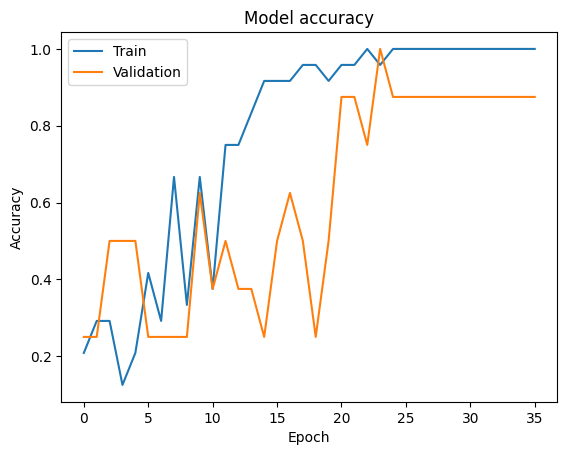

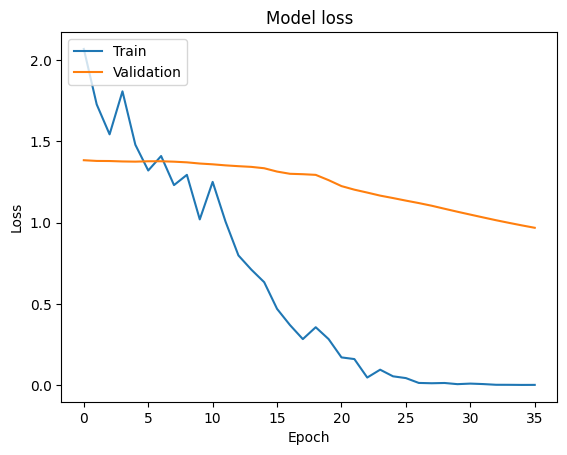

In [ ]:
plot_history(best_history)

## Model Test


In [ ]:
from tensorflow.keras.models import load_model

grid_model = "best_model_grid_overall.h5"

# This is the model that was the one shared in the group
original_model = "intra_model_original.h5"


# Load the best model
models_path = '/content/drive/My Drive/Group Project/Models_Simple_Intra/'
best_model = load_model(models_path + grid_model)

In [ ]:
best_model.summary()

In [ ]:
# Evaluate the model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 22ms/step


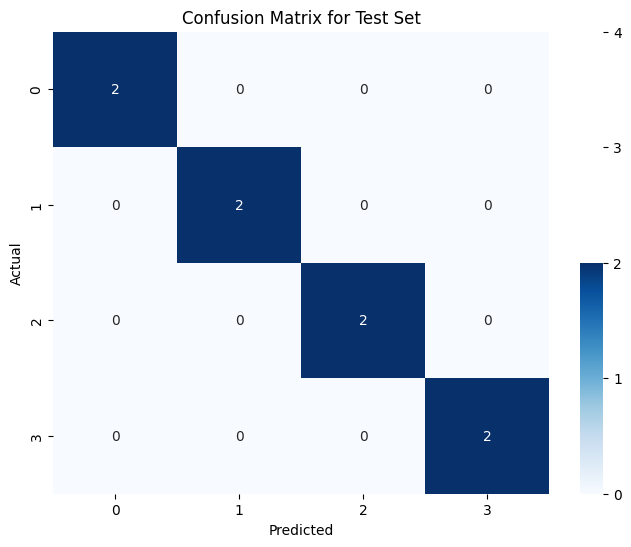

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrices
cm1 = confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(cm, title, name_file):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Modify the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1, 2, 3, 4])  # Set ticks here
    colorbar.set_ticklabels(['0', '1', '2', '3', '4'])  # Set tick labels here
    save_path = '/content/drive/My Drive/Group Project/Models_Simple_Intra/' + name_file
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# Plotting each confusion matrix
plot_confusion_matrix(cm1, 'Confusion Matrix for Test Set', "intra_cm.png")